Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [20]:
# Load packages
library("tidymodels")
library("readr")
library("moderndive")


We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [8]:
# Read data
hate_crimes <- read_csv("http://bit.ly/2ItxYg3")

# Preview data
hate_crimes |> head()


Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


state,median_house_inc,share_pop_metro,hs,hate_crimes,trump_support,unemployment,urbanization,income
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
New Mexico,low,0.69,83,0.295,low,high,low,46686
Maine,low,0.54,90,0.616,low,low,low,51710
New York,low,0.94,85,0.351,low,low,high,54310
Illinois,low,0.90,86,0.195,low,high,high,54916
Delaware,high,0.90,87,0.323,low,low,high,57522
Rhode Island,high,1.00,85,0.095,low,high,high,58633


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_parallel_slopes()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


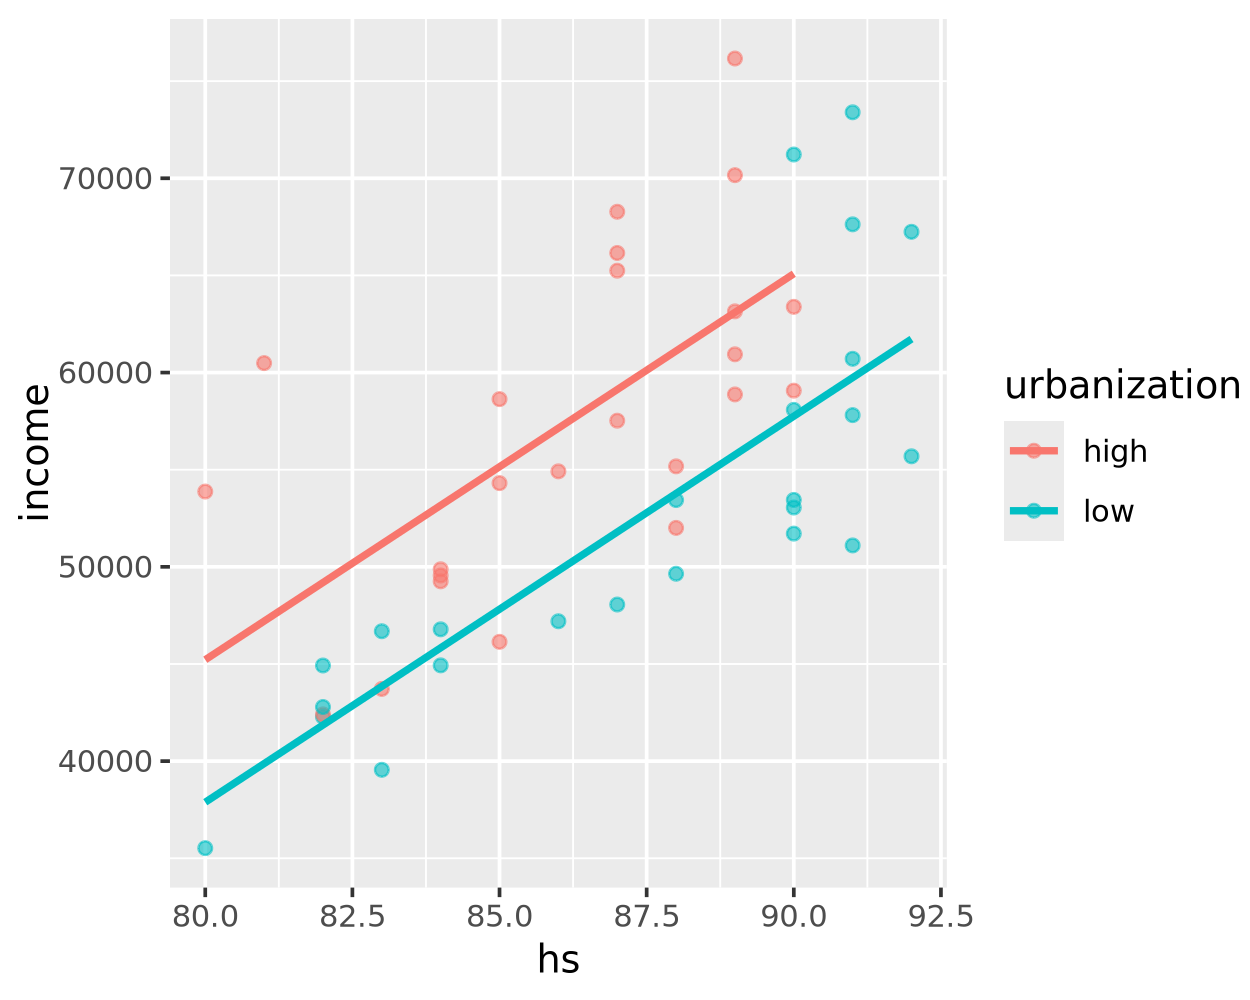

In [19]:
# Create scatterplot
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point(alpha = 0.6) +  # Add scatter points
  geom_parallel_slopes(se = FALSE)  # Add regression lines with parallel slopes
 

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

> The high urbanization region seems to have the higher income as the intercept



Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


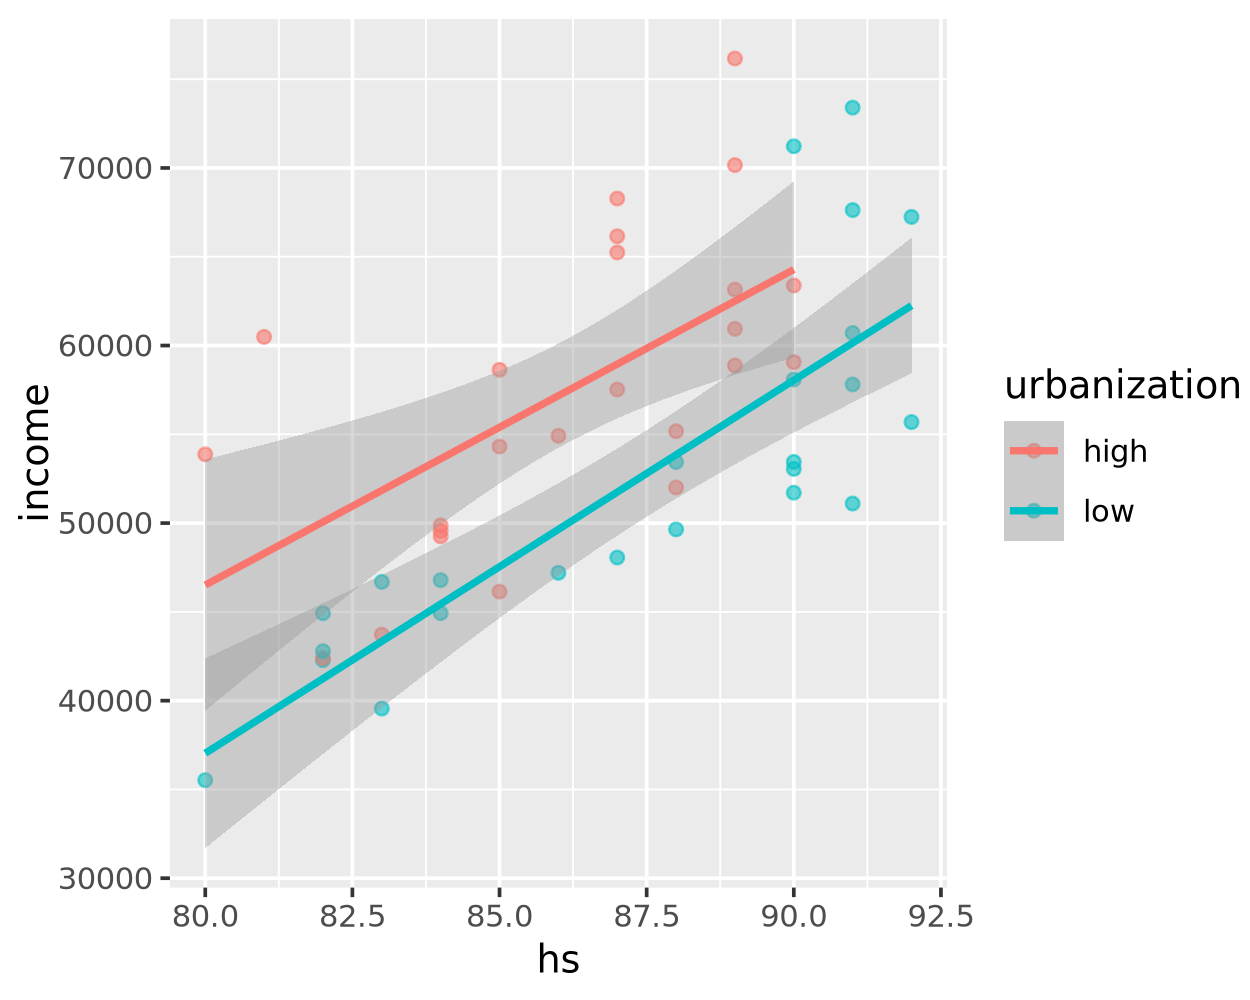

In [21]:
# Create scatterplot
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point(alpha = 0.6) +  # Add scatter points
  geom_smooth(method = "lm") # Draw lines


❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

> I believe it would be bettwe to run a more complex interaction model in order to capture the differences in the 2 slopes and to be able to accurately compare them.



Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [25]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [27]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...
nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    step_interact(~ starts_with("urbanization"):hs) |> # create interaction vars
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

nps_mod = mod |> fit(income ~ ., juice(ps_rec))

nps_mod




parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
urbanization_low_x_hs  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [34]:
# Create table of model predictions 
predict_tbl <- rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)

predict_tbl |> head()

income,.pred,.resid,model
<dbl>,<dbl>,<dbl>,<chr>
46686,43845.37,2840.6311,parallel_slopes
51710,57752.93,-6042.9257,parallel_slopes
54310,55152.28,-842.2822,parallel_slopes
54916,57139.08,-2223.0760,parallel_slopes
57522,59125.87,-1603.8699,parallel_slopes
58633,55152.28,3480.7178,parallel_slopes


In [35]:
# Calculate Coeff. of Determination
predict_tbl |> # Full dataset
    group_by(model) |> # Group rows by the model variable
    summarize(r_squared = var(.pred) / var(income))

model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [36]:
glance(ps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

> The adjusted portion of variance the interaction and parallel slopes model are 0.5747 and 0.5716, respectively. Since these values are relatively the same I would argue that either method could be prefered. However, since the interaction model is slightly closer to 1 than the parallel slopes model it could be argued that this model explains the variance slightly better. 



❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

In [37]:
tidy(nps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-95647.4274,39937.8800,-2.3949050,0.0209485906
hs,1776.9938,463.2497,3.8359312,0.0003953977
urbanization_low,-35393.9651,49893.5228,-0.7093900,0.4818248864
urbanization_low_x_hs,323.9987,575.6838,0.5628067,0.5764231616


> The intercept value indicates that income is greater in states that have **higher** levels of urbanization by about **$35,393 more** than states with low urbanization (shown by the urbanization_low term)

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

> For every 1% increase of high-school educated adults, income **increases by $1,776.99**, on average.


